# Operational Intelligence

Capture data in realtime and draw dashboards. Ideally, you want to open a syslog daemon directly on top of the Spark Streaming context and receive data in near realtime. The idea is to aggregate, visualize, monitor, and alert any non-normative behavior.


In [ ]:
# To generate the socket stream, use the following code
from pyspark.streaming import StreamingContext

# Create the streamingcontext
ssc = StreamingContext(sc)

# Create a DStream that will connect to hostname:port, like localhost:9999
log_lines = ssc.socketTextStream("localhost", 9998)

# Start the socket monitor
ssc.start()

# Run perpetually updating the dahsboards constantly.
ssc.awaitTermination()

# Local Context

Since we are running in a notebook context, let us just demonstrate the log processing with local log files. We are using log file sample downloaded from https://github.com/elastic/examples/tree/master/ElasticStack_apache

In [5]:
# Read the log file
log_lines = sc.textFile('apache_logs.txt')

# Review the format
log_lines.take(1)

[u'83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"']

# Parse the log

In [6]:
import apache_log_parser

# Make a parser to parse out the web line
line_parser = apache_log_parser.Parser("%h %l %u %t \"%r\" %s %b \"%{Referer}i\" \"%{User-Agent}i\"")

# Parse and return interesting bits
def parse_line(logline):
    # Parse and return the dict as a Row of DataFrame
    row_dict = {}
    try:
        row_dict = { k:v for (k,v) in line_parser.parse(logline).iteritems() if 'datetimeobj' not in k}
    except:
        pass
    return row_dict

# For each log line, parse and show the parse result
import pprint
pprint.pprint(sc.parallelize(log_lines.take(1)).map(parse_line).filter(lambda x: len(x) > 5).collect()[0])

# Show a preview of the parse in a table form
# Collect only hits from mobile devices
log_lines_df = log_lines.map(parse_line).filter(lambda x: len(x) > 5).map(lambda x: Row(**x)).toDF(sampleRatio=0.5)

# Display the data
display(log_lines_df.limit(10).toPandas())

{'remote_host': u'83.149.9.216',
 'remote_logname': u'-',
 'remote_user': u'-',
 'request_first_line': u'GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1',
 'request_header_referer': u'http://semicomplete.com/presentations/logstash-monitorama-2013/',
 'request_header_user_agent': u'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36',
 'request_header_user_agent__browser__family': u'Chrome',
 'request_header_user_agent__browser__version_string': '32.0.1700',
 'request_header_user_agent__is_mobile': False,
 'request_header_user_agent__os__family': 'Mac OS X',
 'request_header_user_agent__os__version_string': '10.9.1',
 'request_http_ver': u'1.1',
 'request_method': u'GET',
 'request_url': u'/presentations/logstash-monitorama-2013/images/kibana-search.png',
 'request_url_fragment': '',
 'request_url_hostname': None,
 'request_url_netloc': '',
 'request_url_password': None,
 'request_url_path'

,remote_host,remote_logname,remote_user,request_first_line,request_header_referer,request_header_user_agent,request_header_user_agent__browser__family,request_header_user_agent__browser__version_string,request_header_user_agent__is_mobile,request_header_user_agent__os__family,request_header_user_agent__os__version_string,request_http_ver,request_method,request_url,request_url_fragment,request_url_hostname,request_url_netloc,request_url_password,request_url_path,request_url_port,request_url_query,request_url_query_dict,request_url_query_list,request_url_query_simple_dict,request_url_scheme,request_url_username,response_bytes_clf,status,time_received,time_received_isoformat,time_received_tz_isoformat,time_received_utc_isoformat
0,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/im...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/images...,,None,,None,/presentations/logstash-monitorama-2013/images...,None,,{},[],{},,None,203023,200,[17/May/2015:10:05:03 +0000],2015-05-17T10:05:03,2015-05-17T10:05:03+00:00,2015-05-17T10:05:03+00:00
1,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/im...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/images...,,None,,None,/presentations/logstash-monitorama-2013/images...,None,,{},[],{},,None,171717,200,[17/May/2015:10:05:43 +0000],2015-05-17T10:05:43,2015-05-17T10:05:43+00:00,2015-05-17T10:05:43+00:00
2,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/pl...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/plugin...,,None,,None,/presentations/logstash-monitorama-2013/plugin...,None,,{},[],{},,None,26185,200,[17/May/2015:10:05:47 +0000],2015-05-17T10:05:47,2015-05-17T10:05:47+00:00,2015-05-17T10:05:47+00:00
3,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/pl...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/plugin...,,None,,None,/presentations/logstash-monitorama-2013/plugin...,None,,{},[],{},,None,7697,200,[17/May/2015:10:05:12 +0000],2015-05-17T10:05:12,2015-05-17T10:05:12+00:00,2015-05-17T10:05:12+00:00
4,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/pl...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/plugin...,,None,,None,/presentations/logstash-monitorama-2013/plugin...,None,,{},[],{},,None,2892,200,[17/May/2015:10:05:07 +0000],2015-05-17T10:05:07,2015-05-17T10:05:07+00:00,2015-05-17T10:05:07+00:00
5,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/im...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/images...,,None,,None,/presentations/logstash-monitorama-2013/images...,None,,{},[],{},,None,430406,200,[17/May/2015:10:05:34 +0000],2015-05-17T10:05:34,2015-05-17T10:05:34+00:00,2015-05-17T10:05:34+00:00
6,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/cs...,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Chrome,32.0.1700,False,Mac OS X,10.9.1,1.1,GET,/presentations/logstash-monitorama-2013/css/fo...,,None,,None,/presentations/logstash-monitorama-2013/css/fo...,None,,{},[],{},,None,38720,200,[17/May/2015:10:05:57 +0000],2015-05-17T10:05:57,2015-05-17T10:05:57+00:00,2015-05-17T10:05:57+00:00
7,83.149.9.216,-,-,GET /presentations/logst

# Browser traffic

In [7]:
# Convert to a local frame
browser_frame = log_lines_df.select('request_header_user_agent__browser__family', 'time_received_isoformat').toPandas()

# Display the preview
display(browser_frame)

,request_header_user_agent__browser__family,time_received_isoformat
0,Chrome,2015-05-17T10:05:03
1,Chrome,2015-05-17T10:05:43
2,Chrome,2015-05-17T10:05:47
3,Chrome,2015-05-17T10:05:12
4,Chrome,2015-05-17T10:05:07
...,...,...
9981,Other,2015-05-20T21:05:15
9982,YandexBot,2015-05-20T21:05:01
9983,Googlebot,2015-05-20T21:05:00
9984,Firefox,2015-05-20T21:05:56


# How does the browser patterns behave?

Cumulate count of browsers on a 6-hour basis and plot

request_header_user_agent__browser__family,360Spider,AOL,AhrefsBot,Amazon Silk,Android,AppEngine-Google,Apple Mail,Baidu Explorer,Baiduspider,Baiduspider-image,BeetleBot,BingPreview,Bon Echo,CFNetwork,Chrome,Chrome Frame,Chrome Mobile,Chrome Mobile iOS,Chromium,Conkeror,Daumoa,ELinks,EasouSpider,Epiphany,Exabot,FacebookBot,Firefox,Firefox Beta,Firefox Mobile,Genieo,GmailImageProxy,Googlebot,Googlebot-Image,Googlebot-Mobile,IE,IE Mobile,Iceweasel,Iron,Konqueror,Lightning,Links,LumiBot,Lynx,MJ12bot,Mail.RU_Bot,Maxthon,Midori,Mobile Safari,Mobile Safari UI/WKWebView,MojeekBot,Nutch,Openwave,Opera,Opera Mini,Other,Pale Moon (Firefox Variant),PhantomJS,Python Requests,Python-urllib,Rekonq,SEMC-Browser,Safari,SeaMonkey,SimplePie,Sogou Explorer,Sogou web spider,TwitterBot,UC Browser,VoilaBot,Xenu Link Sleuth,Yahoo! Slurp,YandexBot,YandexDirect,YandexImages,YisouSpider,archive.org_bot,archiver/3.1.1 +http://www.archive.org/details/archive.org_bot,bingbot,com/bot,favicon,ia_archiver,magpie-crawler,msnbot,msnbot-media,psbot,robot
time_received_isoformat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-05-17 06:00:00,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,14.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2015-05-17 12:00:00,0.0,0.0,0.0,24.0,12.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,2.0,166.0,0.0,38.0,26.0,28.0,12.0,4.0,0.0,0.0,2.0,2.0,2.0,288.0,0.0,0.0,0.0,0.0,46.0,0.0,2.0,42.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,4.0,0.0,222.0,0.0,0.0,0.0,0.0,0.0,0.0,168.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,20.0,10.0,0.0,14.0,0.0,42.0,8.0,6.0,0.0,0.0,0.0,2.0,184.0,0.0,10.0,6.0
2015-05-17 18:00:00,2.0,0.0,0.0,10.0,6.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,8.0,544.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,312.0,0.0,0.0,0.0,2.0,90.0,0.0,4.0,22.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,44.0,20.0,0.0,0.0,12.0,16.0,0.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,16.0,0.0,12.0,0.0,42.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2015-05-18 00:00:00,2.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,302.0,0.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,32.0,12.0,278.0,0.0,0.0,0.0,0.0,104.0,2.0,8.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,24.0,12.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,10.0,0.0,0.0,10.0,0.0,224.0,2.0,8.0,0.0,6.0,0.0,2.0,0.0,8.0,0.0,0.0
2015-05-18 06:00:00,4.0,0.0,0.0,0.0,28.0,0.0,0.0,2.0,16.0,0.0,4.0,0.0,0.0,6.0,554.0,0.0,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,300.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,34.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,0.0,0.0,14.0,0.0,236.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,16.0,38.0,0.0,2.0,0.0,2.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-19 18:00:00,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,10.0,562.0,16.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,398.0,0.0,0.0,0.0,0.0,52.0,0.0,2.0,88.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,116.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,24.0,42.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0
2015-05-20 00:00:00,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,698.0,0.0,0.0,0.0,44.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0,50.0,2.0,2.0,30.0,0.0,54.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4

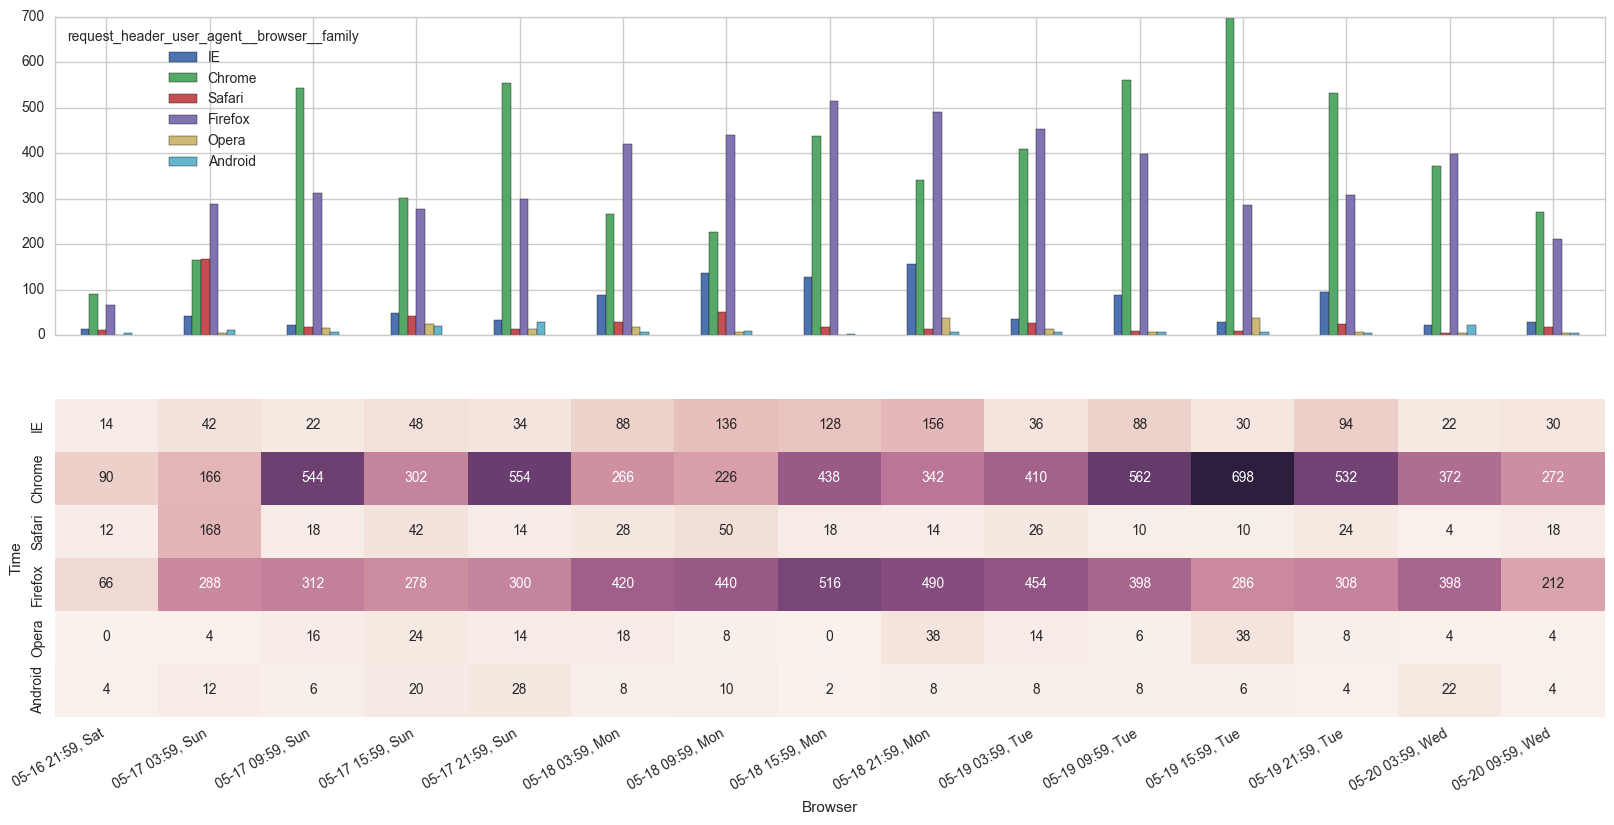

In [8]:
%matplotlib inline
# Pivot first so all status codes become columns
pivoted_table = pd.pivot_table(browser_frame, index=['time_received_isoformat'], columns=['request_header_user_agent__browser__family'], aggfunc=np.count_nonzero)
# Also resample and aggregate in weekly intervals
hourly_counts = pivoted_table.set_index(pd.to_datetime(pivoted_table.index)).resample('6H').sum().fillna(0)
# Display the preview
display(hourly_counts)

# Plot the time series chart
# We will add counts in integer form, so project everything as int
chart_data = hourly_counts[['IE', 'Chrome', 'Safari', 'Firefox', 'Opera', 'Android']].astype(int)

# Make the time axis labels pretty
from matplotlib.dates import IndexDateFormatter, DateFormatter
from datetime import datetime
fmt = DateFormatter('%m-%d %H:%M, %a')
chart_data['Time'] = chart_data.index

#Convert to localtime and add a new column
offset = datetime.now() - datetime.utcnow()
chart_data['Time'] = chart_data['Time'].apply(lambda x: fmt.strftime(x + offset))

chart_data.set_index('Time', inplace=True)

# ============================
# Create a figure
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.set_style("whitegrid")

# Plot the bar chart
chart_data.plot(kind='bar', ax=ax[0])

# Plot the heatmap on the same axis
sns.heatmap(chart_data.T, annot=True, fmt="d", ax=ax[1], cbar=False)
ax[1].set(xlabel='Browser', ylabel='Time')
fig.autofmt_xdate()

# Findings

1. We find the activity peaks in the evening (PST) versus midnight, midday, or dawn
2. It is a very short window but it looks like Tuesday seems like a peak day for business
3. Chrome and Firefox seem to be the eminent browsers.

<hr />